# LLM Society: A Complete Guide

Welcome! This notebook is a comprehensive, step-by-step tutorial designed to guide a new user through all the core features of the `llm-society` package. We will start with the absolute basics and progressively build up to the most advanced capabilities.

By the end of this tutorial, you will know how to:

1.  Run a basic simulation.
2.  Customize networks and agent personas.
3.  Use the powerful **External Shocks `events` framework** to script complex scenarios.
4.  Enable **Dynamic Networks** that evolve based on agent conversations.
5.  Visualize, analyze, and export your results.

## 1. Setup

### Installation

First, ensure you have all the required packages installed. From your terminal, run:
```bash
pip install -r requirements.txt
```

### OpenAI API Key

This package uses OpenAI's models to power the agent conversations. You need to provide an API key. The easiest way is to create a file named `api-key.txt` in the root of this project and paste your key into the first line.

Alternatively, you can set it as an environment variable. The cell below shows how to do this within the notebook for a single session.

**Important:** Replace `"<YOUR_OPENAI_API_KEY>"` with your actual key.


In [1]:
# Note: It is recommended to use the `api-key.txt` file for security.
# This method is shown for convenience.
import os

os.environ['OPENAI_API_KEY'] = "<YOUR_OPENAI_API_KEY>"


In [2]:
from llm_society.api import network
from llm_society.viz import set_theme

# Apply a beautiful theme for all subsequent plots
set_theme()


## 2. Your First Simulation: The Basics

Let's start by running a simulation with the simplest possible configuration. We only need to provide the piece of information we want to simulate the diffusion of. All other parameters will use sensible defaults.

The `network()` function is the main entry point to the package. It creates a `Network` object that holds all our configuration and results.

### Customizing the Network & Simulation

The real power of `llm-society` comes from its customizability. Let's create a new, larger, and more densely connected network that runs for more rounds.

- `n`: The total number of agents (nodes) in the network.
- `degree`: The average number of connections each agent has.
- `rounds`: The number of simulation steps to run.

In [6]:
# Create a network with a piece of information to be diffused.
net_basic = network(
    information="Direct air capture is a scalable solution for carbon removal.",
    n=8,           # small graph
    degree=2,      # sparse connectivity
    rounds=8,      # keep it short
    seeds=[1],     # initial nodes
    talk_prob=0.8, # probability a sampled pair discusses the claim
    rng=42         # set a random seed for reproducibility
)

# Run the simulation!
# This is where the magic happens: agents talk to each other and update their beliefs.
net_basic.simulate()

print("Simulation complete!")


Round 0 summary: Most ratings for the credibility of direct air capture as a scalable carbon removal solution are low, with almost all scores clustering near the bottom of the scale.

=== Conversation 0 <-> 6 ===
0: Honestly, I’m not really convinced direct air capture is all that scalable for tackling carbon. It seems super expensive and just not practical for actually making a real difference.
6: I get what you’re saying—I’ve heard it costs a ton and just doesn’t seem realistic to do on a big scale. There’s got to be more practical ways to deal with the issue than betting on some big machine to clean the air.
=== End Conversation 0 <-> 6 ===

Score update 0<->6 (credibility): 0 0.00 -> 0.00, 6 0.00 -> 0.00

=== Conversation 0 <-> 7 ===
0: I don't really buy into the hype about direct air capture. It sounds good on paper, but I haven't seen enough evidence that it's realistic or cost-effective on a large scale.
7: I feel the same way, honestly. It’s one of those ideas that makes headl

### Basic Visualization

Now that the simulation has run, we can visualize the results. The `.plot()` method is a versatile tool for this. Let's look at two fundamental plot types:

1.  `"final"`: Shows a heatmap of the final belief scores of all agents, overlaid on the network graph itself. This gives a great snapshot of the final state.
2.  `"coverage"`: Shows how the information spread over time. It plots the percentage of the network that has been "exposed" to the information in each round.


> **A Note on `ffmpeg`**
>
> You might have encountered a `RuntimeError: Requested MovieWriter (ffmpeg) not available` when running plotting code for the first time.
>
> **What is it?** `ffmpeg` is a powerful open-source tool for handling video and audio. `matplotlib`, the library this package uses for plotting, relies on `ffmpeg` to create and save animations (like `.mp4` or `.gif` files).
>
> **Do I need it?**
> - For displaying static plots (like `"final"`, `"coverage"`, etc.) in a notebook, you **do not** need it.
> - You **only** need `ffmpeg` if you want to *save* an animation to a file (e.g., `net.plot(type="animation", save="my_animation.mp4")`).
>
> **How to install it (optional):**
> If you need to save animations, you can install it on your system.
> - **macOS (with Homebrew):** `brew install ffmpeg`
> - **Linux (Debian/Ubuntu):** `sudo apt-get install ffmpeg`
> - **Windows:** You can download a build from the [official website](https://ffmpeg.org/download.html).


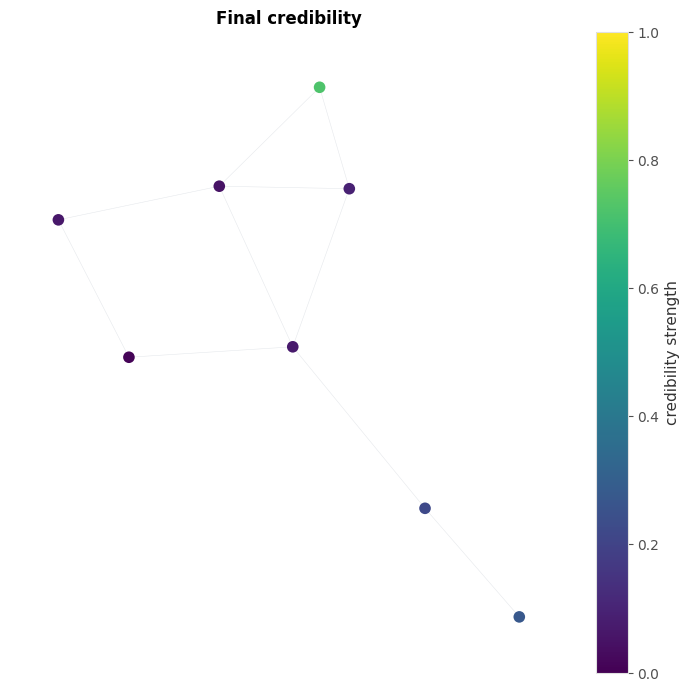

In [7]:
# Plot the final scores on the network graph.
# Node color represents the credibility score (brighter = higher belief).
net_basic.plot(type="final")


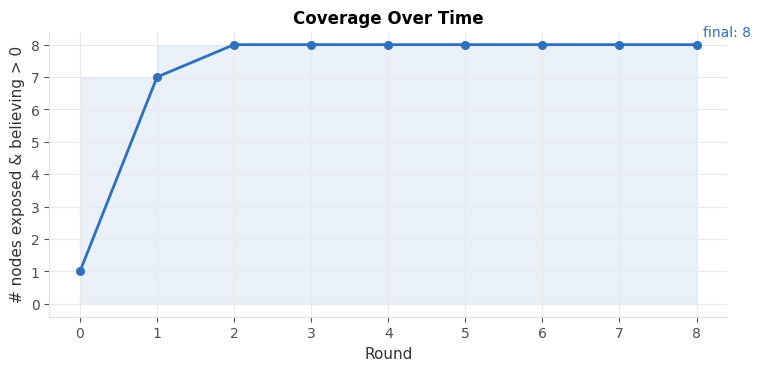

In [8]:
# Plot the coverage of the information over the simulation rounds.
net_basic.plot(type="coverage")


## 3. Personas & Multi-Metric Scoring

So far, our agents have been generic. The simulation becomes much more realistic and interesting when we define *who* these agents are. We can do this by defining **persona segments**.

### Defining Persona Segments

A "segment" is a group of agents sharing a set of traits. We define them in a list, where each segment has:
- `proportion`: The fraction of the total network population this segment represents.
- `name`: A descriptive name for the segment.
- `traits`: A dictionary of key-value pairs that define the persona. You can define any traits you want!

Let's create two distinct segments: "Optimists" who are generally trusting of technology, and "Skeptics" who are more critical.


In [3]:
# Define two groups with different inherent traits
persona_segments = [
    {
        "proportion": 0.5,
        "name": "Tech Optimists",
        "traits": {
            "political": "Center-left",
            "personality": "Open and curious",
            "trust_in_institutions": "High",
        }
    },
    {
        "proportion": 0.5,
        "name": "Tech Skeptics",
        "traits": {
            "political": "Libertarian",
            "personality": "Analytical and cautious",
            "trust_in_institutions": "Low",
        }
    }
]


### Multi-Metric Scoring

By default, the simulation only tracks one metric: `credibility`. However, human belief is more complex than a single number. We can configure the simulation to track multiple dimensions of an agent's response to information.

We do this by passing a list to the `metrics` parameter. Each metric needs:
- `id`: A short, unique identifier (used for plotting).
- `label`: A human-readable name.
- `prompt`: The specific instruction we give to the LLM for how to score this metric on a 0-1 scale.

Let's track both the `credibility` of the information and the `emotional_valence` (positive/negative feeling) it evokes.


In [10]:
# Define the metrics we want the LLM to evaluate
metrics = [
    {
        "id": "credibility",
        "label": "Credibility Score",
        "prompt": "Rate the credibility of the claim on a 0.0 to 1.0 scale."
    },
    {
        "id": "emotion",
        "label": "Emotional Valence",
        "prompt": "Rate the emotional valence of the response on a 0.0 (very negative) to 1.0 (very positive) scale."
    }
]


In [11]:
# Now, let's create a simulation using both personas and multiple metrics
net_personas = network(
    information="Universal Basic Income (UBI) is the key to automating the economy without leaving people behind.",
    n=20,
    degree=5,
    rounds=12,
    segments=persona_segments,
    metrics=metrics,
    rng=456
)

net_personas.simulate()
print("Persona-based simulation complete!")


Round 0 summary: The distribution of Credibility Scores is heavily skewed toward low values for the Universal Basic Income topic.

=== Conversation 15 <-> 17 ===
15: Sounds good to me! What’s been on your mind lately?
17: Honestly, I’ve been thinking about how much technology is creeping into every part of our lives. Sometimes I wonder if we’re moving too fast and not questioning things enough.
15: I totally get what you mean. It feels like every new thing we use ends up collecting data or trying to change how we act, and barely anyone really asks if it’s actually good for us.
17: Exactly, it's like everything is just designed to make us spend more time or money without us even noticing. Sometimes I wonder if all this tech is actually helping or just making life more complicated.
(No information discussed; scores unchanged.)
=== End Conversation 15 <-> 17 ===


=== Conversation 6 <-> 15 ===
6: Sure thing! What's been on your mind lately?
15: Honestly, I’ve just been thinking about how 

### Group-Based Analysis

Defining personas isn't just for making the simulation more realistic; it's for analysis! We can now see how different groups responded to the information.

The `.plot()` method has a `"group"` type that lets us visualize the average score trajectories for different segments.

- `by="segment"`: Compares the named segments we defined (e.g., "Tech Optimists" vs "Tech Skeptics").
- `by="traits"` with `attr="..."`: Compares groups based on a specific trait value (e.g., all "Center-left" agents vs all "Libertarian" agents).


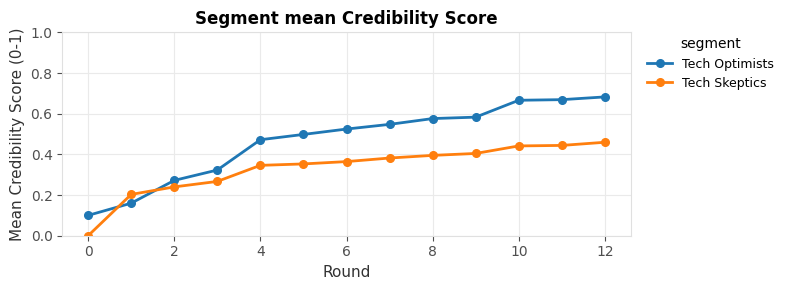

In [12]:
# Compare the average credibility score between our two named segments
net_personas.plot(type="group", by="segment", metric="credibility")


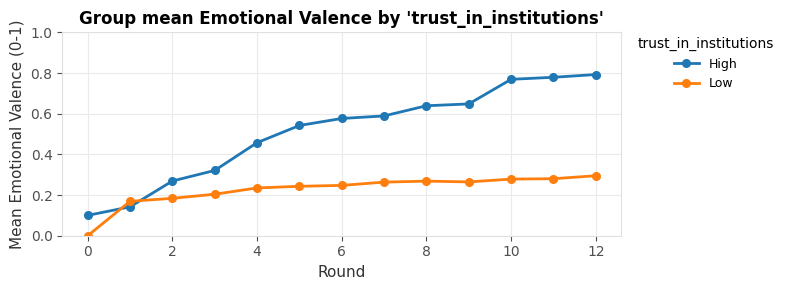

In [13]:
# Now let's see the average emotional response, grouped by the "trust_in_institutions" trait
net_personas.plot(type="group", by="traits", attr="trust_in_institutions", metric="emotion")


## 4. The Events Framework: Scripting Your Simulation

Simulations become truly powerful when they can react to external changes, just like in the real world. The **Events Framework** allows you to "script" a series of external shocks that occur at specific rounds.

This is the modern and flexible way to handle interventions, inject new information, or (in the future) trigger other types of changes.

An "event" is a dictionary with three key properties:
- `round`: The round number on which the event should trigger.
- `type`: The kind of event to execute. We'll demonstrate two key types:
    - `intervention`: The classic intervention, where a specific message is given to a set of agents.
    - `information_injection`: A powerful new event that introduces a *new* piece of information to a subset of the network.
- `...other_params`: Additional parameters depending on the event type, such as `nodes`, `content`, `seed_score`, etc.

Let's design a scenario:
- **Round 4**: An official health organization (an `intervention`) tries to promote the benefits of a new dietary supplement.
- **Round 8**: A conspiracy theory blog (an `information_injection`) starts spreading a rumor that the supplement is harmful.


In [5]:
# Let's use the same personas from before, as their traits will influence how they react.

events_scenario = [
    {
        "round": 3,
        "type": "intervention",
        "nodes": [0, 1, 2, 3, 4], # Target a few initial nodes
        "content": "Remember to consider the scientifically proven benefits of the new VitaPlus supplement."
    },
    {
        "round": 7,
        "type": "information_injection",
        "nodes": [5, 6, 7, 8], # Target a different group of nodes
        "information": "Warning: The VitaPlus supplement contains untested synthetic compounds.",
        "seed_score": 0.95, # The nodes receiving this believe it strongly
        "metric": "credibility" # This injection specifically targets the 'credibility' metric
    }
]


In [5]:
net_events = network(
    information="The new dietary supplement 'VitaPlus' is now available.",
    n=10,
    degree=5,
    rounds=10,
    segments=persona_segments, # Using our Optimist/Skeptic personas
    events=events_scenario,
    rng=789
)

net_events.simulate()
print("Events-based simulation complete!")


Round 0 summary: Most participants rated the credibility of 'VitaPlus' as low, with ratings clustered near the bottom of the scale.

=== Conversation 2 <-> 4 ===
2: Sure thing! What’s on your mind?
4: Not much, just relaxing a bit after a busy day. How about you?
(No information discussed; scores unchanged.)
=== End Conversation 2 <-> 4 ===


=== Conversation 1 <-> 2 ===
1: Of course, what’s on your mind today? Anything fun or interesting happening?
2: Not much, just enjoying the day and catching up on some tech news. Have you come across anything cool or surprising lately?
(No information discussed; scores unchanged.)
=== End Conversation 1 <-> 2 ===


=== Conversation 4 <-> 8 ===
4: Sure, that sounds good to me! What's been on your mind lately?
8: Honestly, I’ve been thinking a lot about how fast technology is moving and how hard it is to trust what’s actually safe or private anymore. Sometimes it feels like no one’s really looking out for us regular people.
4: I totally get what you

### Visualizing Event Impact

The `"intervention"` plot type is perfect for seeing the effect of events. It plots the average score over time and adds vertical lines to mark when interventions (or other events) occurred.

Let's see how our two segments, the "Optimists" and "Skeptics," reacted differently to this scripted scenario.


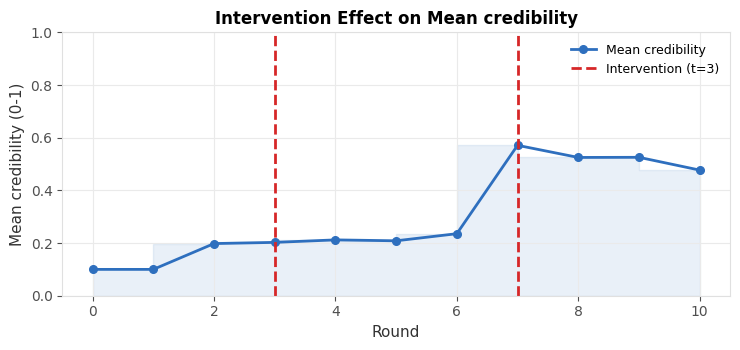

In [6]:
# The plot automatically finds the intervention rounds from the events list.
# We can group by segment to see the differential impact.
net_events.plot(type="intervention", by="segment")


## 5. Dynamic Networks: Bringing Your Simulation to Life

This is one of the most advanced features of `llm-society`. So far, the network structure (who is connected to whom) has been static. With **Dynamic Networks**, the social fabric itself evolves based on the agents' conversations.

### How It Works

When `dynamic_network` is enabled, we empower the LLM to act as a social judge. After every conversation, the LLM not only scores the agents' beliefs but also provides a **new tie strength** for their relationship, based on their original connection and the quality of the conversation.

This leads to two powerful emergent behaviors:

- **Link Formation**: If two previously unconnected agents have a positive conversation, a new link can form between them, creating a new social connection.
- **Link Severing**: If two connected agents have a very negative or conflict-ridden conversation, their tie strength can drop so low that their link is severed entirely.

### Enabling Dynamic Networks

To enable this feature, you need to set three key parameters:
1.  `dynamic_network=True`: The master switch to turn the feature on.
2.  `conversation_scope="all"`: This is **required** because it allows conversations to happen between any pair of agents, not just already connected ones, which is necessary for new links to form.
3.  `link_formation_threshold` / `link_sever_threshold`: The thresholds that determine when a new link is strong enough to be created, or an old one is weak enough to be destroyed.


In [10]:
# Let's run a simulation where a controversial topic might cause the network to restructure itself.
# We'll use the same Optimist/Skeptic personas.

net_dynamic = network(
    information="Strongly regulating major tech companies is the only way to ensure user privacy and safety.",
    n=10,
    degree=3,
    rounds=20, # Dynamic networks often need more rounds to show significant changes
    segments=persona_segments,
    rng=101,
    
    # --- Enable Dynamic Network ---
    dynamic_network=True,
    conversation_scope="all",
    link_formation_threshold=0.4,
    link_sever_threshold=0.05,
)

net_dynamic.simulate()
print("Dynamic network simulation complete!")


Round 0 summary: Most ratings indicate low credibility, with only a small portion perceiving strong credibility for this topic.

=== Conversation 5 <-> 8 ===
5: Sure thing, man. What’s been on your mind lately?
8: Hey, not much, just keeping an eye on how fast tech is moving these days. Feels like there’s always something new to be skeptical about, you know?
5: Yeah, totally get that—it’s moving so fast it’s hard to know what to trust anymore. I always feel like there’s some catch or downside that gets glossed over.
8: Man, I hear you. It feels like every new tech thing comes with a string nobody talks about until it’s too late.
5: Exactly, it's like there's always a catch they hope you don't notice till you're already locked in. Makes you wonder who they're really building this stuff for.
8: Yeah, it always feels like these tech companies are looking out for themselves first. I try to dig into the fine print, but sometimes it feels like a full-time job just to keep up.
(No information

### Observing the Evolution

The best way to see the result of a dynamic network simulation is to watch an animation of its evolution.

Pay close attention to the structure of the graph as it changes over the rounds. You may notice:
- **Clusters**: Groups of nodes that are tightly connected to each other but sparsely connected to other groups. This is a sign of community formation (or echo chambers!).
- **Isolated Nodes**: Agents who, through negative interactions, have been cut off from the main network.
- **Link Severing/Formation**: Watch as edges disappear after contentious conversations and new edges appear between like-minded agents.

The emergence of structure is the key result of this powerful feature, and an animation makes it plain to see.


In [11]:
# Color the nodes by their segment name to see if the network has split along persona lines.
# An animation is the best way to visualize the dynamic network evolution.
net_dynamic.plot(type="animation", save="dynamic_network_animation.mp4")


## 6. Analysis & Exporting

Visualizations are powerful, but sometimes you need the raw numbers and text. `llm-society` provides easy ways to get a statistical summary and export all the data from your simulation.

### Summary Report

The `.summary_report()` method generates a professional, OLS-like statistical report of the simulation's results. It's a fantastic way to quickly get key metrics like final coverage, score distributions, and even polarization gaps if your personas have a "political" trait.


In [12]:
# Let's get the summary report for our dynamic network simulation
report = net_dynamic.summary_report()
print(report)


                             LLM Society Simulation Summary                             
════════════════════════════════════════════════════════════════════════════════════════
Model Information
────────────────────────────────────────────────────────────────────────────────────────
Model:                       gpt-4.1
Mode:                        llm
Agents (n):                  10
Rounds:                      20
Mean degree:                 3
Edge sampling frac:          0.50
Talk prob:                   0.25
Convo depth intensity:       0.60

Fit Statistics
────────────────────────────────────────────────────────────────────────────────────────
Final coverage:              10 (100.00% of n)
Time to 50% coverage:        t = 1
Credibility mean (std):      0.442 (0.341)
Credibility median [p10, p90]: 0.250 [0.140, 0.880]
Share credibility ≥ 0.7:     30.00%
Share credibility ≤ 0.3:     60.00%
Corr(credibility, degree):   0.45

LLM Narrative Summary (last round)
────────────────────────

### Exporting Raw Data

For in-depth analysis in other tools (like R, Stata, or even Excel), you can export the simulation data using the `.export()` method.

You can export:
- `history_csv`: A round-by-round summary.
- `scores_csv`: The full score trajectory for every single agent.
- `conversations_jsonl`: A file containing every conversation that took place, in a structured JSONL format.


In [13]:
# Create a directory to store our exported data
output_dir = "tutorial_outputs"
os.makedirs(output_dir, exist_ok=True)

# Export the data from our most complex simulation
net_dynamic.export(
    history_csv=f"{output_dir}/history.csv",
    scores_csv=f"{output_dir}/scores_by_round.csv",
    conversations_jsonl=f"{output_dir}/conversations.jsonl",
)

print(f"Data exported to the '{output_dir}' directory!")


Data exported to the 'tutorial_outputs' directory!


## 7. Conclusion

Congratulations! You've now journeyed through all the core features of the `llm-society` package, from a simple simulation to a complex, evolving social network with external shocks.

You are now equipped to:
- Design agents with custom personas.
- Track multiple psychological metrics.
- Script complex scenarios with the events framework.
- Simulate the evolution of social ties themselves.
- Analyze and export your findings.

The real fun begins now. Try experimenting with different persona traits, more complex event chains, and observe the fascinating, emergent social dynamics that unfold.

For more details on any specific parameter, you can always consult the package's source code or the project's README. Happy simulating!
